In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from sklearn.preprocessing import MinMaxScaler as mms
from tslearn.preprocessing import TimeSeriesScalerMinMax as tmms
from sklearn.cluster import MiniBatchKMeans
from tslearn.clustering import TimeSeriesKMeans

from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from modules.models.autoencoders import VanillaAutoEncoder, RecurrentAutoEncoder, ConvAutoEncoder
from modules.models.clusterers import IDEC
from modules.comparison import compare_clusterers

### Tabular Data - RNA Seq

In [3]:
X = np.load('data\\tabular\\rna_seq\\X.npy', allow_pickle=True).astype('float32')
y = np.load('data\\tabular\\rna_seq\\y.npy', allow_pickle=True).astype('float32')
X = mms().fit_transform(X)
reduction = np.load('results\\umap_reductions\\rna_seq.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'data\\tabular\\rna_seq\\X.npy'

In [93]:
vanilla = VanillaAutoEncoder(
    X_shape=X.shape
)

stopper = EarlyStopping(
    monitor='loss',
    min_delta=0.0001,
    patience=10,
    restore_best_weights=True
)
history = vanilla.fit(
    X.astype('float32'), 
    epochs=1000, 
    batch_size=32, 
    callbacks=[stopper],
    verbose=0
)

In [94]:
clusterer_idec = IDEC(
    X=X,
    autoencoder=vanilla,
    n_clusters=5,
    gamma=0.1
)
clusterer_idec.fit(
    X=X,
    epochs=100,
    btch_size=32,
    verbose=False,
    update_interval=10
)

Tol: 0.001 Delta: 0.0
Stop Training


In [95]:
clusterer_kmeans = MiniBatchKMeans(
    n_clusters=5,
    n_init=100,
    max_iter=300
)
clusterer_kmeans.fit(
    X
)

MiniBatchKMeans(max_iter=300, n_clusters=5, n_init=100)

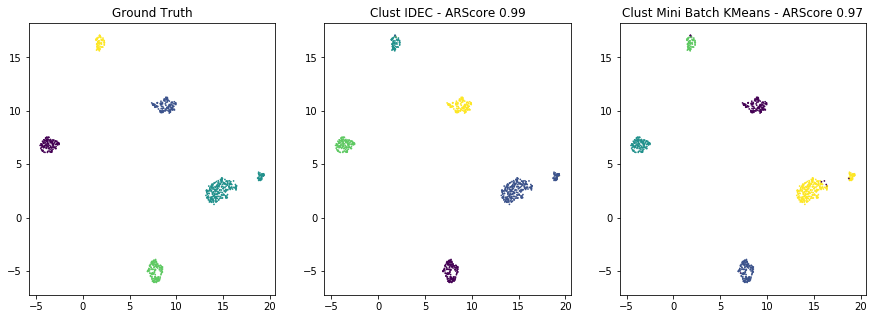

In [7]:
compare_clusterers(
    clusterer_1={'IDEC': clusterer_idec.predict(X).argmax(1).flatten()}, 
    clusterer_2={'Mini Batch KMeans': clusterer_kmeans.labels_}, 
    ground_truth=y, 
    reduction=reduction,
    figsize=(15, 5),
    s=0.5
)

### Time Series Data - NATOPS dataset

In [22]:
X = np.load('data\\time_series\\natops\\X.npy', allow_pickle=True).astype('float32')
y = np.load('data\\time_series\\natops\\y.npy', allow_pickle=True).astype('float32')
X = tmms().fit_transform(X)
reduction = np.load('results\\umap_reductions\\natops.npy')

In [23]:
recurrent = RecurrentAutoEncoder(X_shape=X.shape)

stopper = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    restore_best_weights=True
)
history = recurrent.fit(
    X, 
    epochs=1000, 
    batch_size=32,
    verbose=0, 
    callbacks=[stopper],
    validation_split=0.2
)

In [24]:
clusterer_idec = IDEC(
    X=X,
    autoencoder=recurrent,
    n_clusters=5,
    gamma=0.05
)
clusterer_idec.fit(
    X=X,
    epochs=300,
    btch_size=32,
    verbose=True,
    update_interval=X.shape[0] // 32,
    epochs_tol=(X.shape[0] // 32) * 5
)

epoch: 1
loss: 0.05798131972551346
kl_divergence: 0.1423054337501526
mse: 0.05086604878306389
epoch: 2
loss: 0.05256551504135132
kl_divergence: 0.17542961239814758
mse: 0.04379403218626976
epoch: 3
loss: 0.04364093765616417
kl_divergence: 0.18032659590244293
mse: 0.0346246063709259
epoch: 4
loss: 0.04302763566374779
kl_divergence: 0.21580109000205994
mse: 0.03223758190870285
epoch: 5
loss: 0.04156867042183876
kl_divergence: 0.17135202884674072
mse: 0.033001068979501724
epoch: 6
loss: 0.03889356553554535
kl_divergence: 0.17051753401756287
mse: 0.030367689207196236
epoch: 7
loss: 0.041217125952243805
kl_divergence: 0.19915318489074707
mse: 0.03125946596264839
epoch: 8
loss: 0.03967828303575516
kl_divergence: 0.2088795155286789
mse: 0.029234305024147034
epoch: 9
loss: 0.038423627614974976
kl_divergence: 0.18927663564682007
mse: 0.028959795832633972
epoch: 10
loss: 0.03872184082865715
kl_divergence: 0.1969764083623886
mse: 0.0288730189204216
epoch: 11
loss: 0.03747721016407013
kl_divergenc

epoch: 86
loss: 0.028826111927628517
kl_divergence: 0.14354339241981506
mse: 0.021648941561579704
epoch: 87
loss: 0.029909946024417877
kl_divergence: 0.14417196810245514
mse: 0.02270134724676609
epoch: 88
loss: 0.029940873384475708
kl_divergence: 0.1626531034708023
mse: 0.021808218210935593
epoch: 89
loss: 0.02993697114288807
kl_divergence: 0.1462693214416504
mse: 0.02262350544333458
epoch: 90
loss: 0.03018479235470295
kl_divergence: 0.1385781168937683
mse: 0.023255886510014534
epoch: 91
loss: 0.028866561129689217
kl_divergence: 0.1423860788345337
mse: 0.021747257560491562
epoch: 92
loss: 0.02924026921391487
kl_divergence: 0.14323827624320984
mse: 0.02207835577428341
epoch: 93
loss: 0.02865363098680973
kl_divergence: 0.13932472467422485
mse: 0.021687394008040428
epoch: 94
loss: 0.028447069227695465
kl_divergence: 0.13778671622276306
mse: 0.021557733416557312
epoch: 95
loss: 0.0277584046125412
kl_divergence: 0.14012403786182404
mse: 0.020752202719449997
epoch: 96
loss: 0.026675602421164

epoch: 170
loss: 0.024332568049430847
kl_divergence: 0.12869231402873993
mse: 0.01789795234799385
epoch: 171
loss: 0.023407183587551117
kl_divergence: 0.130206897854805
mse: 0.016896838322281837
epoch: 172
loss: 0.024697113782167435
kl_divergence: 0.12583397328853607
mse: 0.01840541511774063
epoch: 173
loss: 0.024211587384343147
kl_divergence: 0.12854254245758057
mse: 0.01778445951640606
epoch: 174
loss: 0.023243514820933342
kl_divergence: 0.12654100358486176
mse: 0.016916465014219284
epoch: 175
loss: 0.02411336451768875
kl_divergence: 0.12980949878692627
mse: 0.017622889950871468
epoch: 176
loss: 0.0230356864631176
kl_divergence: 0.12476743757724762
mse: 0.016797315329313278
epoch: 177
loss: 0.023515993729233742
kl_divergence: 0.12881803512573242
mse: 0.01707509160041809
epoch: 178
loss: 0.025161534547805786
kl_divergence: 0.12375743687152863
mse: 0.018973663449287415
epoch: 179
loss: 0.025416411459445953
kl_divergence: 0.12453024834394455
mse: 0.019189897924661636
epoch: 180
loss: 0.

In [25]:
clusterer_dtw_kmeans = TimeSeriesKMeans(
    n_clusters=5, 
    metric='dtw', 
    max_iter=100,
    n_init=5,
    max_iter_barycenter=5
)
clusterer_dtw_kmeans.fit(
    X
)

TimeSeriesKMeans(max_iter=100, max_iter_barycenter=5, metric='dtw',
                 n_clusters=5, n_init=5)

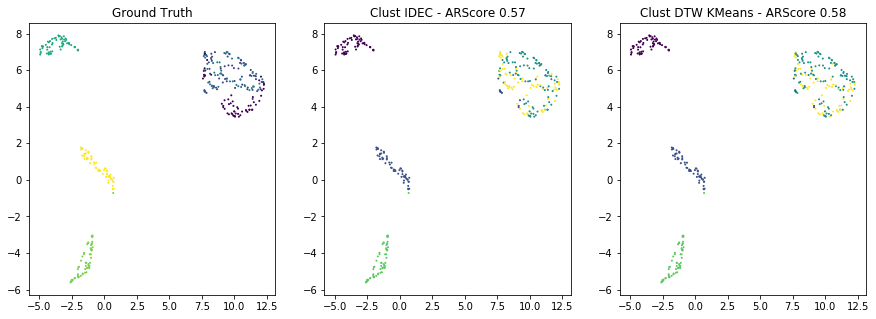

In [26]:
compare_clusterers(
    clusterer_1={'IDEC': clusterer_idec.predict(X).argmax(1).flatten()}, 
    clusterer_2={'DTW KMeans': clusterer_dtw_kmeans.labels_}, 
    ground_truth=y.flatten(), 
    reduction=reduction,
    figsize=(15, 5),
    s=1
)

### Images Data - Olivetti

In [16]:
X = np.load('data\\images\\olivetti\\X.npy').reshape((-1, 64, 64, 1))
y = np.load('data\\images\\olivetti\\y.npy', allow_pickle=True).astype('float32')
reduction = np.load('results\\umap_reductions\\olivetti.npy')

In [17]:
convol = ConvAutoEncoder(X_shape=X.shape)

stopper = EarlyStopping(
    monitor='loss',
    min_delta=0.00001,
    patience=20,
    restore_best_weights=True
)
history = convol.fit(
    X,
    noise=0.01,
    epochs=1000, 
    batch_size=64,
    callbacks=[stopper],
    verbose=0
)

In [19]:
clusterer_idec = IDEC(
    X=X,
    autoencoder=convol,
    n_clusters=40,
    gamma=0.5,
    labels=y
)
clusterer_idec.fit(
    X=X,
    epochs=1000,
    btch_size=64,
    update_interval=X.shape[0] // 64,
    epochs_tol=(X.shape[0] // 64) * 5,
    verbose=True
)

epoch: 1
loss: 0.24575237929821014
kl_divergence: 1.633615056562121e-07
mse: 0.24575230479240417
epoch: 2
loss: 0.07218393683433533
kl_divergence: 6.256787855818402e-06
mse: 0.07218080759048462
epoch: 3
loss: 0.045411959290504456
kl_divergence: 1.1304335203021765e-05
mse: 0.04540630802512169
epoch: 4
loss: 0.027382206171751022
kl_divergence: 8.094280929071829e-05
mse: 0.027341734617948532
epoch: 5
loss: 0.03187117353081703
kl_divergence: 0.00010913155711023137
mse: 0.03181660920381546
epoch: 6
loss: 0.021324031054973602
kl_divergence: 2.128734195139259e-05
mse: 0.021313387900590897
epoch: 7
loss: 0.021164270117878914
kl_divergence: 6.919267889315961e-06
mse: 0.021160811185836792
epoch: 8
loss: 0.0186458807438612
kl_divergence: 9.429377314518206e-06
mse: 0.018641166388988495
epoch: 9
loss: 0.016701102256774902
kl_divergence: 9.141918781097047e-06
mse: 0.01669653132557869
epoch: 10
loss: 0.015515269711613655
kl_divergence: 1.2580618204083294e-05
mse: 0.015508979558944702
epoch: 11
loss: 

In [20]:
clusterer_kmeans = MiniBatchKMeans(
    n_clusters=40,
    n_init=100,
    max_iter=300
)
clusterer_kmeans.fit(
    X.reshape(X.shape[0], -1)
)

MiniBatchKMeans(max_iter=300, n_clusters=40, n_init=100)

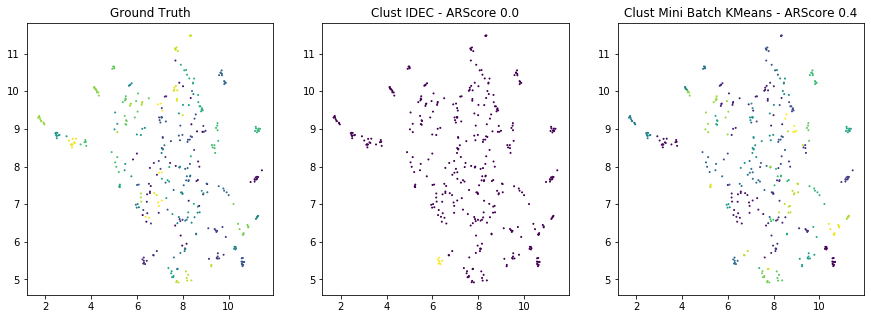

In [21]:
compare_clusterers(
    clusterer_1={'IDEC': clusterer_idec.predict(X).argmax(1).flatten()}, 
    clusterer_2={'Mini Batch KMeans': clusterer_kmeans.labels_}, 
    ground_truth=y, 
    reduction=reduction,
    figsize=(15, 5),
    s=1
)